## Centrality Dependence of CNM Effects

### Setup, Import & Preprocess

In [1]:
# --- setup (nPDF only) ---
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path
sys.path.append("./code")

from npdf_module import (
    NPDFSystem, RpAAnalysis,
    WoodsSaxonPb, CentralityModel, GluonFromGrid, step_band_from_left_edges,style_axes, step_band_xy, centers_to_left_edges
)
from gluon_ratio import EPPS21Ratio, GluonEPPSProvider

# I/O
pPb5_dir = "./input/npdf/pPb5TeV"
pPb8_dir = "./input/npdf/pPb8TeV"
outdir   = Path("./output-npdf-comparisons"); outdir.mkdir(exist_ok=True)

# energies (inelastic σ_NN in mb)
sigma5, sigma8 = 67.0, 71.0

plt.rcParams.update({
    "figure.dpi": 130,
    "font.size": 12,
    "axes.grid": False,          # ← no grid by default
    "axes.spines.top": True,     # ← show top frame
    "axes.spines.right": True,   # ← show right frame
})

# analysis windows (edit as needed)
CENT_EDGES = [0,20,40,60,80,100]      # centrality bins (%)
Y_RANGES_THREE = [(-4.46,-2.96), (-1.37,0.43), (2.03,3.53)]  # Back, Mid, For
Y_LABELS       = ["-4.46 < y < -2.96", "-1.37 < y < 0.43", "2.03 < y < 3.53"]
PT_RANGE   = (1.5, 20.0)
# --- load nPDF sstems and grids (Hessian bands preserved) ---
ana  = RpAAnalysis()

sys5 = NPDFSystem.from_folder(pPb5_dir, kick="pp", name="p+Pb 5.02 TeV")
r5   = ana.compute_rpa_grid(sys5.df_pp, sys5.df_pa, sys5.df_errors, join="intersect")
SA5  = GluonFromGrid(sys5.df_pp, sys5.df_pa)

sys8 = NPDFSystem.from_folder(pPb8_dir, kick="pp", name="p+Pb 8.16 TeV")
r8   = ana.compute_rpa_grid(sys8.df_pp, sys8.df_pa, sys8.df_errors, join="intersect")
SA8  = GluonFromGrid(sys8.df_pp, sys8.df_pa)

geom = WoodsSaxonPb()
cm5  = CentralityModel.from_inputs(SA5, geom)
cm8  = CentralityModel.from_inputs(SA8, geom)

# Build providers (use the same A and √sNN you’re analyzing)
epps5 = GluonEPPSProvider(EPPS21Ratio(A=208,  path="./input/npdf/nPDFs"),
                          sqrt_sNN_GeV=5023.0, m_state_GeV="charmonium",
                          y_sign_for_xA=-1)   # default: x_A ~ e^{-y}
epps8 = GluonEPPSProvider(EPPS21Ratio(A=208, path="./input/npdf/nPDFs"),
                          sqrt_sNN_GeV=8160.0, m_state_GeV="charmonium",
                          y_sign_for_xA=-1)

In [2]:
# print(cm5)
# print(cm8)

In [3]:
# EPPS providers (standard forward/backward)
cm5 = cm5.enable_matched_from_analysis(ana, sys5.df_pp, sys5.df_pa, sys5.df_errors, epps5, centralK=False)
cm8 = cm8.enable_matched_from_analysis(ana, sys8.df_pp, sys8.df_pa, sys8.df_errors, epps8, centralK=False)

In [4]:
# print(cm5)
# print(cm8)

In [5]:
# cm5.gluon = epps5
# cm8.gluon = epps8
# print(cm5)
# print(cm8)

### Min bias

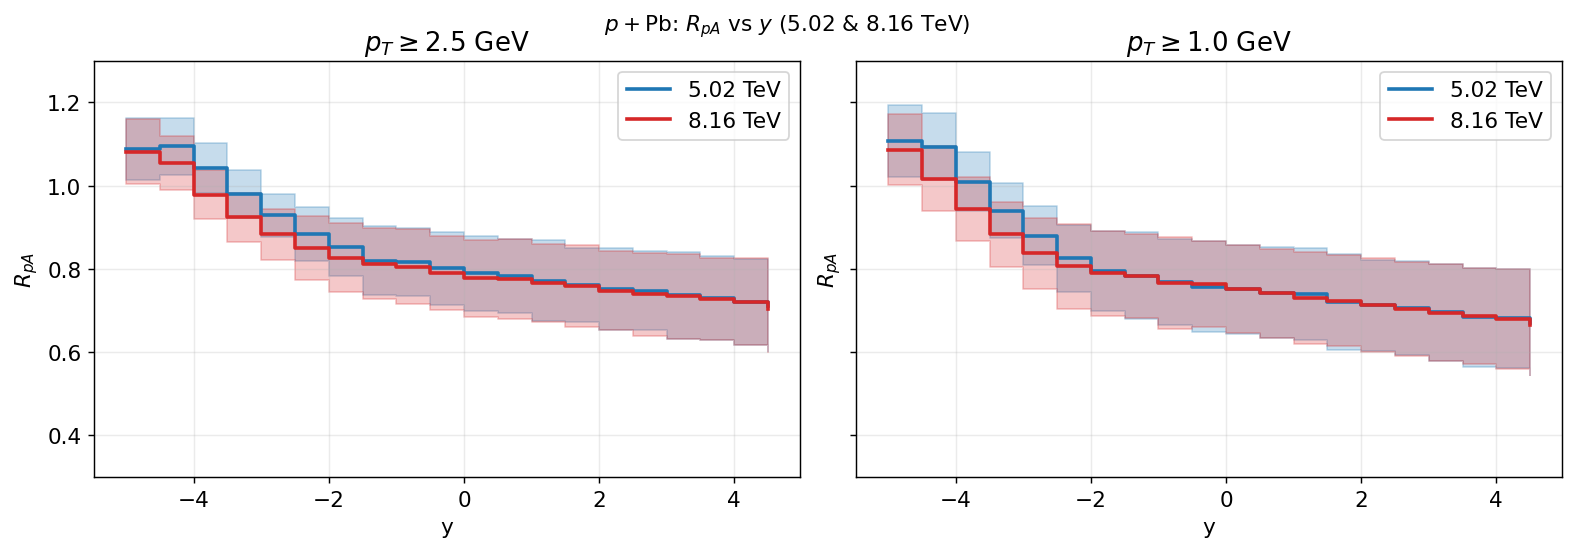

In [6]:
# RpA vs y: 5.02 & 8.16 TeV on one figure
# LEFT panel:  pT >= 2.5 GeV
# RIGHT panel: pT >= 1.0 GeV
pairs = [("5.02", sys5, r5), ("8.16", sys8, r8)]
# compute once
results = {}
for tag, sysX, rgrid in pairs:
    df_1p0  = ana.rpa_vs_y_pt_threshold(rgrid, sysX.df_pa, pt_min=1.0)
    df_2p5  = ana.rpa_vs_y_pt_threshold(rgrid, sysX.df_pa, pt_min=2.5)
    results[(tag, "1.0")] = (df_1p0, sysX)
    results[(tag, "2.5")] = (df_2p5, sysX)
    # optional: save CSVs like before
    # df_1p0.to_csv(f"{outdir}/rpa_vs_y_{tag.replace('.','p')}TeV_ptmin1p0.csv", index=False)
    # df_2p5.to_csv(f"{outdir}/rpa_vs_y_{tag.replace('.','p')}TeV_ptmin2p5.csv", index=False)

def _x_edges(sysX, df):
    # keep your original edge logic, but robust
    if getattr(sysX, "y_edges", None) is not None and len(sysX.y_edges) == len(df):
        return sysX.y_edges.values
    return centers_to_left_edges(df["y"].values)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4),
                         sharex=True, sharey=True, constrained_layout=True)

# panel specs: left=2.5, right=1.0
panel_specs = [("2.5", r"$p_T \geq 2.5$ GeV"),
               ("1.0", r"$p_T \geq 1.0$ GeV")]

# consistent colors per energy
colors = {"5.02": "tab:blue", "8.16": "tab:red"}

for ax, (ptkey, panel_title) in zip(axes, panel_specs):
    for tag in ["5.02", "8.16"]:
        df, sysX = results[(tag, ptkey)]
        x = _x_edges(sysX, df)
        step_band_xy(ax, x,
                     df["r_central"], df["r_lo"], df["r_hi"],
                     label=f"{tag} TeV", color=colors[tag])
    style_axes(ax, "y", r"$R_{pA}$", title=panel_title)
    ax.set_ylim(0.3, 1.3)
    ax.legend()

fig.suptitle(r"$p+$Pb: $R_{pA}$ vs $y$ (5.02 & 8.16 TeV)", y=1.02, fontsize=12)
fig.savefig(f"{outdir}/rpa_vs_y_5TeV_8TeV_ptpanels.pdf", bbox_inches="tight")
plt.show()

In [7]:
cm5.debug_point(y=3.0, pt=5.0, b=5.0, 
                df_pp=sys5.df_pp, df_pa=sys5.df_pa, 
                df_errors=sys5.df_errors, 
                gluon=epps5, msg="TEST")

[TEST] at (y,pt,b)=(2.750,4.750,5.00)
  pp=3.289000e+00  pa=2.471000e+00  r0=pa/pp=0.751292
  SA_c=0.736497  alpha(b)=0.630239  Nnorm=1.363837  Kc=1.050252
  RpA_c = r0*Kc = 0.789046
  #members=48; first 6 r0(mem)=[0.737002128306476, 0.7667984189723319, 0.7534204925509274, 0.738826391000304, 0.7123745819397993, 0.7278808148373366]


In [8]:
systems = [("5.02", sys5, r5), ("8.16", sys8, r8)]

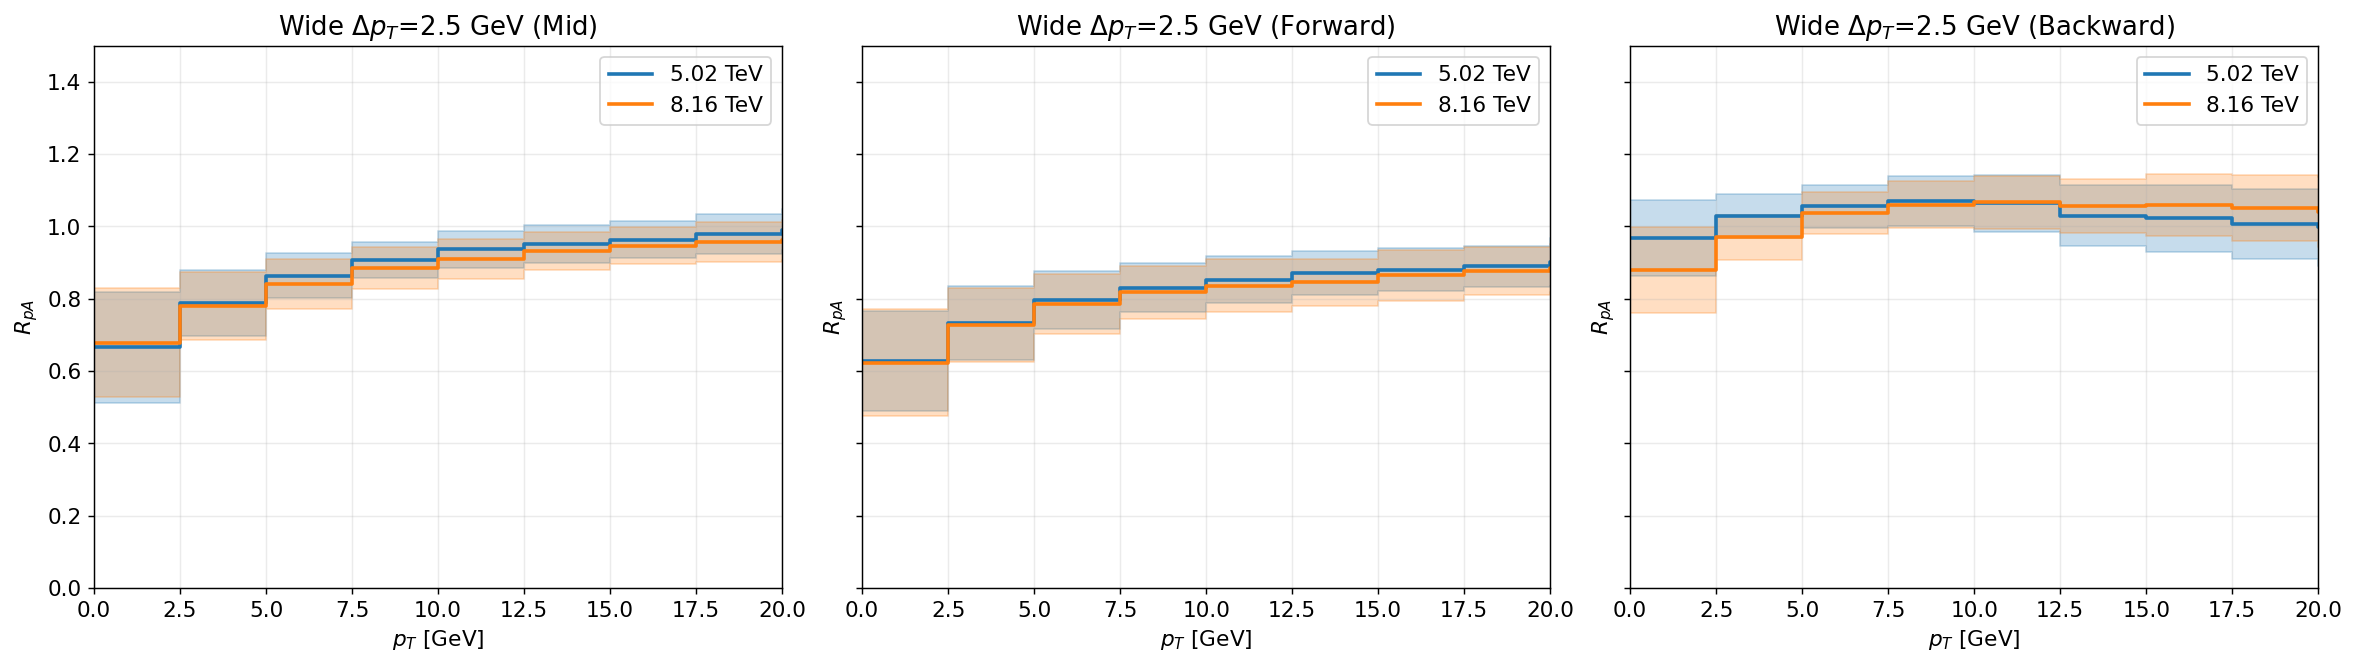

In [9]:
# Only include the systems you want to plot.
# y_windows = [(-1.93, 1.93, "Mid"),  # CMS
#              ( 1.5,  4.0, "Forward"),
#              (-5.0, -2.5, "Backward")]
y_windows = [(-1.37,0.43, "Mid"),  # CMS
             ( 2.03,3.53, "Forward"),
             (-4.46,-2.96, "Backward")]

# The number of rows is now 1, to overlay the plots.
n_windows = len(y_windows)
fig, axes = plt.subplots(nrows=1, ncols=n_windows, figsize=(6 * n_windows, 5),
                         sharex=True, sharey=True, constrained_layout=True)

# If n_windows is 1, `axes` is not an array. This makes it iterable.
if n_windows == 1:
    axes = [axes]

# Loop over the plot columns (y_windows) first, then over the systems.
for j, (ymin, ymax, name) in enumerate(y_windows):
    ax = axes[j]  # Select the current subplot

    # Loop through each system (5.02 and 8.16) and plot it on the *same* axis `ax`
    for tag, sysX, rgrid in systems:
        # Compute the data for the current system
        wide = ana.rpa_vs_pt_widebins(rgrid, sysX.df_pa, y_min=ymin, y_max=ymax, width=2.5)
        
        # Save data with a unique name to avoid overwriting files
        # wide.to_csv(f"{outdir}/rpa_vs_pt_wide_{tag}TeV_y{ymin}_to_{ymax}.csv", index=False)

        # Plot on the current subplot, using the system tag for the legend
        step_band_from_left_edges(ax, wide["pt_left"], wide["r_central"], wide["r_lo"], wide["r_hi"],
                                  label=f"{tag} TeV")

    # Style the axes *after* both systems have been plotted
    # The title is now more general since it contains multiple systems.
    style_axes(ax, r"$p_T$ [GeV]", r"$R_{pA}$", title=f"Wide Δ$p_T$=2.5 GeV ({name})")
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 1.5)
    ax.legend()  # Create the legend, which will now show "5.02 TeV" and "8.16 TeV"

# Save the combined figure after the loop
fig.savefig(f"{outdir}/rpa_vs_pt_wide_comparison_LHC.pdf", bbox_inches="tight")

# Display the figure
plt.show()

### Debugging

In [10]:
import numpy as np
y, pT = 0.0, 2.0
b_grid = np.linspace(0, 10, 11)
SA = epps5.SA_ypt_set([y], [pT], set_id=1)[0]
K = [epps5.K_ypt_b_set(y, pT, b, set_id=1) for b in b_grid]
print("SA=", SA, "  K(b=0)~", K[0], "  K(b~10)~", K[-1])

SA= 0.7415917138575533   K(b=0)~ 0.873221865125689   K(b~10)~ 1.3479926838980143


In [11]:
print("N (AWS) =", cm5.Nnorm)
print("N (AWS) =", cm8.Nnorm)

N (AWS) = 1.363836752898261
N (AWS) = 1.363836752898261


In [12]:
# S_A parity
base = cm5._matched["base_xy"].sample(200, random_state=0)
y, pt = base["y"].to_numpy(), base["pt"].to_numpy()
SA_p = np.asarray(epps5.SA_ypt_set(y, pt, set_id=1), float)

rg   = pd.DataFrame({"y":y, "pt":pt, "r_central":np.ones_like(y)})
rg2  = cm5.attach_SA_to_grid(rg, verbose=True)
SA_m = rg2["SA"].to_numpy(float)
print("max |ΔS_A| =", np.nanmax(np.abs(SA_p - SA_m)))   # → ~1e-12

# K(b) parity
bvals = np.linspace(0, 12, 5)
y0, p0 = 0.0, 2.0
K_p = np.array([epps5.K_ypt_b_set(y0, p0, b, set_id=1) for b in bvals], float)
K_m = np.array([cm5.K_of(y0, p0, b) for b in bvals], float)
print("max |ΔK| =", np.nanmax(np.abs(K_p - K_m)))       # → ~1e-12

# Centrality closure
b_chk = cm5.centrality_table([0,60,80,100]).query("cent_bin=='80-100%'")["b_mean"].item()
base, r0 = cm5._matched["base_xy"], cm5._matched["r0"]
mask = base["y"].between(-1.37,0.43) & base["pt"].between(1.5,20.0)
y, pt = base.loc[mask,"y"].to_numpy(), base.loc[mask,"pt"].to_numpy()
w = sys5.df_pa.merge(base[mask], on=["y","pt"], how="inner")["val"].to_numpy(float)
K = np.array([cm5.K_of(float(yy), float(pp), float(b_chk)) for yy,pp in zip(y,pt)], float)
lhs = np.sum(w * r0[mask.to_numpy()] * K) / np.sum(w)
rhs = cm5.rpa_vs_b(r5, sys5.df_pa, -1.37, 0.43, 1.5, 20.0, b_values=[b_chk], verbose=False)["r_central"].iloc[0]
print("closure |lhs-rhs| =", abs(lhs - rhs))            # → ≤1e-3 purely from fp/binning

max |ΔS_A| = 0.0
max |ΔK| = 1.1022655092007838e-06
closure |lhs-rhs| = 1.1102230246251565e-16


In [13]:
cm5.debug_point(y=-2, pt=1, b=7.0,
               df_pp=sys5.df_pp, df_pa=sys5.df_pa, df_errors=sys5.df_errors,
               gluon=cm5.gluon, msg="PERIPH y=-3, pT=1")

[PERIPH y=-3, pT=1] at (y,pt,b)=(-2.250,0.750,7.00)
  pp=4.695000e-01  pa=-9.565000e-01  r0=pa/pp=-2.037274
  SA_c=0.887602  alpha(b)=0.144107  Nnorm=1.363837  Kc=1.101743
  RpA_c = r0*Kc = -2.244552
  #members=48; first 6 r0(mem)=[-2.4749733759318424, -2.078168264110756, -1.7550585729499468, -2.856230031948882, -2.617678381256656, -2.626198083067093]


In [14]:
check = sys8.df_pa.merge(sys8.df_pp, on=["y","pt"], suffixes=("_pa","_pp"))
check["ratio"] = check.val_pa / check.val_pp
print(check[(check.y.between(-5,-1)) & (check.pt<2.5)])

        y    pt     val_pa  err_pa   val_pp  err_pp     ratio
0   -4.75  0.25   0.140700  0.2935   0.5929  0.2653  0.237308
1   -4.75  0.75   3.125000  0.5039   2.7750  0.5327  1.126126
2   -4.75  1.25   6.687000  0.4744   6.4380  0.5082  1.038677
3   -4.75  1.75  11.470000  0.5347  10.6100  0.4777  1.081056
4   -4.75  2.25  11.970000  0.4347  10.6000  0.5379  1.129245
100 -4.25  0.25   0.009514  0.3372   0.3396  0.3417  0.028015
101 -4.25  0.75   1.808000  0.5220   1.7430  0.6172  1.037292
102 -4.25  1.25   5.911000  0.5380   7.4050  0.6269  0.798244
103 -4.25  1.75  11.050000  0.4153  11.3800  0.5624  0.971002
104 -4.25  2.25  14.310000  0.4312  14.0800  0.5274  1.016335
200 -3.75  0.25  -0.691200  0.2677  -0.7130  0.2845  0.969425
201 -3.75  0.75   1.250000  0.5151   3.1090  0.6462  0.402059
202 -3.75  1.25   4.283000  0.5895   6.5790  0.6562  0.651011
203 -3.75  1.75  10.950000  0.4345  12.1500  0.5122  0.901235
204 -3.75  2.25  13.860000  0.4280  14.7900  0.4888  0.937120
300 -3.2

In [15]:
# Pick a peripheral b (use centrality_table to see typical values)
b_periph = cm5.centrality_table([0,60,80,100]).query("cent_bin=='80-100%'")["b_mean"].item()
print(b_periph)

for y in [-3,-1,0,1,-2.5]:
    for p in [0.25, 0.5, 1.25, 1.5, 2.0, 2.5, 4.0]:
        cm5.debug_point(y=y, pt=p, b=b_periph,
                    df_pp=sys5.df_pp, df_pa=sys5.df_pa, df_errors=sys5.df_errors,
                    gluon=cm5.gluon, msg=f"MB y={y}, pT={p}")

7.934062101217263
[MB y=-3, pT=0.25] at (y,pt,b)=(-3.250,0.250,7.93)
  pp=5.505000e-02  pa=-2.885000e-01  r0=pa/pp=-5.240690
  SA_c=1.059850  alpha(b)=0.035019  Nnorm=1.363837  Kc=0.946227
  RpA_c = r0*Kc = -4.958883
  #members=48; first 6 r0(mem)=[-7.538601271571298, -6.368755676657584, -6.019981834695731, -6.913714804722979, -8.563124432334241, -8.54677565849228]
[MB y=-3, pT=0.5] at (y,pt,b)=(-3.250,0.250,7.93)
  pp=5.505000e-02  pa=-2.885000e-01  r0=pa/pp=-5.240690
  SA_c=1.059850  alpha(b)=0.035019  Nnorm=1.363837  Kc=0.946227
  RpA_c = r0*Kc = -4.958883
  #members=48; first 6 r0(mem)=[-7.538601271571298, -6.368755676657584, -6.019981834695731, -6.913714804722979, -8.563124432334241, -8.54677565849228]
[MB y=-3, pT=1.25] at (y,pt,b)=(-3.250,1.250,7.93)
  pp=6.004000e+00  pa=4.393000e+00  r0=pa/pp=0.731679
  SA_c=1.069503  alpha(b)=0.035019  Nnorm=1.363837  Kc=0.938117
  RpA_c = r0*Kc = 0.686401
  #members=48; first 6 r0(mem)=[0.725016655562958, 0.725516322451699, 0.736675549633577

In [16]:
# 1) α(b) table — should decrease monotonically toward periphery and be O(1) in 0–20%
cm5._alpha_cache = {}  # clear cache to ensure new code runs
print(cm5._alphas_for_bins([0,20,40,60,80,100], sigmaNN_mb=sigma5))

# 2) Min-bias self-consistency — 0–100% centrality with K(b) must match the pure min-bias integral
mb   = cm5.minbias_in_window(r5, sys5.df_pa, y_min=-4.5, y_max=3.5, pt_min=2.5, pt_max=20.0)
full = cm5.rpa_vs_centrality_integrated(r5, sys5.df_pa, [0,100], 
                                        y_min=-4.5, y_max=3.5, pt_min=2.5, pt_max=20.0,
                                        sigmaNN_mb=sigma5, weight="inelastic")
print("MB (direct):     ", mb)
print("MB via 0–100%:   ", full)
# r_central and the band limits should agree within numerical noise (~1e-3).

# quick self-check (should be ~1e-3 agreement)
chk = cm5.rpa_vs_centrality_integrated(r5, sys5.df_pa, [0,100], 
                                        y_min=-4.5, y_max=3.5, pt_min=2.5, pt_max=20.0,
                                        sigmaNN_mb=sigma5, weight="inelastic")
mb5 = cm5.minbias_in_window(r5, sys5.df_pa, y_min=-4.5, y_max=3.5, pt_min=2.5, pt_max=20.0)
print("MB-0–100% diff (5 TeV):",
      float(mb5["r_central"]-chk["r_central"].iloc[0]),
      float(mb5["r_lo"]-chk["r_lo"].iloc[0]),
      float(mb5["r_hi"]-chk["r_hi"].iloc[0]))

[('0-20%', 0.9252530851685401), ('20-40%', 0.7460083043749048), ('40-60%', 0.5132752726227356), ('60-80%', 0.2518684454699252), ('80-100%', 0.061491743516858106)]
[rpa_vs_centrality_integrated] window: y∈[-4.5,3.5], pT∈[2.5,20.0]  weight_mode=pa
  bin 0-100%: alpha=0.690113, points=560, wsum=6.576e+02
MB (direct):      {'r_central': 0.8436085264960228, 'r_lo': 0.7763556544310937, 'r_hi': 0.9108613985609519}
MB via 0–100%:      cent_bin  r_central      r_lo     r_hi
0   0-100%   0.851613  0.770436  0.93279
[rpa_vs_centrality_integrated] window: y∈[-4.5,3.5], pT∈[2.5,20.0]  weight_mode=pa
  bin 0-100%: alpha=0.690113, points=560, wsum=6.576e+02
MB-0–100% diff (5 TeV): -0.008004875612998341 0.005919263560566712 -0.021929014786563394


### Helpers & Plotter

In [17]:
# single function to convert edges+vals to step plotting format
def as_step(edges, vals):
    e = np.asarray(edges, float)
    v = np.asarray(vals,  float)
    return e, np.r_[v, v[-1]]

def note(ax, y_rng, pt_rng, cent_edges, loc=(0.62,0.02)):
    txt = fr"${y_rng[0]:.2f} < y < {y_rng[1]:.2f}$" + "\n" + fr"${pt_rng[0]:.1f} < p_T < {pt_rng[1]:.1f}$ GeV"
    ax.text(*loc, txt, transform=ax.transAxes, va="bottom", ha="left",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9), fontsize=10)
    
# --- styling constants (keep your existing _cosmetics and as_step) ---
BAND_COLOR = "C0"     # same blue for both
LS_5, LS_8 = "-", "--"
BAND_ALPHA = 0.20
BAND_ALPHA_SOLID = 0.30
HATCH_8 = "////"      # hatch for 8.16 TeV band
MB_BAND_COLOR = "C1"  # distinct color for min-bias bands
# single place to enforce small cosmetics on every axis we draw
def _cosmetics(ax):
    # show all spines, but no ticks on top/right
    for s in ax.spines.values():
        s.set_visible(True)
    ax.tick_params(axis="both", which="both", top=False, right=False)
    # minor ticks on RpA (y-axis)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis="y", which="minor", length=3, width=0.8)
    ax.tick_params(axis="y", which="major", length=5, width=1.0)
    # ensure grid stays off unless you turn it on explicitly
    ax.grid(False)

def _ranges_box(ax, y_rng, pt_rng, xy=(0.02, 0.96)):
    """Single range box (y & pT) at the top-left inside the panel."""
    txt = fr"{y_rng[0]:.2f} < $y$ < {y_rng[1]:.2f}" + "\n" + fr"{pt_rng[0]:.1f} < $p_T$ < {pt_rng[1]:.1f} GeV"
    ax.text(xy[0], xy[1], txt, transform=ax.transAxes, ha="left", va="top",
            fontsize=10, bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9))
    
def _cent_box(ax, cent_label, xy=(0.02, 0.96)):
    ax.text(xy[0], xy[1], cent_label, transform=ax.transAxes,
            ha="left", va="top", fontsize=10,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9))

def _kine_box(ax, lines, xy=(0.02, 0.04)):
    ax.text(xy[0], xy[1], "\n".join(lines), transform=ax.transAxes,
            ha="left", va="bottom", fontsize=10,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9))

In [18]:
def as_step(edges, vals):
    """Turn per-bin values into step arrays for drawstyle='steps-post'."""
    e = np.asarray(edges, float)
    v = np.asarray(vals,  float)
    return e, np.r_[v, v[-1]]

def note(ax, y_rng, pt_rng, cent_edges, loc=(0.62,0.02)):
    txt = fr"${y_rng[0]:.2f}, < y < {y_rng[1]:.2f}$" + "\n" + fr"${pt_rng[0]:.1f} < p_T < {pt_rng[1]:.1f}$ GeV"
    ax.text(*loc, txt, transform=ax.transAxes, va="bottom", ha="left",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9), fontsize=10)

def rpa_vs_centrality_table(cm, rgrid, df_pa, cent_edges, y_rng, pt_rng, sigma_mb):
    """nPDF-only band per centrality bin."""
    return cm.rpa_vs_centrality_integrated(
        rgrid, df_pa, cent_edges,
        y_min=y_rng[0], y_max=y_rng[1],
        pt_min=pt_rng[0], pt_max=pt_rng[1],
        sigmaNN_mb=sigma_mb, weight="inelastic", verbose=False
    )

def _norm_cent(s):
    s = str(s).replace("–","-").replace("%","").strip()
    a,b = [float(x) for x in s.split("-")]
    f = lambda x: (str(int(round(x))) if abs(x-round(x))<1e-8 else f"{x:g}")
    return f"{f(a)}-{f(b)}%"

def _cent_labels(edges):
    return [f"{edges[i]}-{edges[i+1]}%" for i in range(len(edges)-1)]

def _step_from_edges(left, right, val):
    """Return X,Y for steps-post using explicit bin edges."""
    L = np.asarray(left,  float)
    R = np.asarray(right, float)
    v = np.asarray(val,   float)
    edges = np.r_[L[0], R]                 # [L0, R0, R1, ...]
    steps = np.r_[v[0], v]                 # hold value to right edge
    return edges, steps


In [19]:
# --- Min-bias distinct look (colors + lighter bands) ---
MB5_COLOR = "C2"   # 5.02 TeV MB (green)
MB8_COLOR = "C1"   # 8.16 TeV MB (orange)
LS_MB_5   = ":"    # 5.02 TeV MB line
LS_MB_8   = "-."   # 8.16 TeV MB line
MB_BAND_ALPHA = 0.18  # lighter than your main bands

def _draw_minbias_band(ax, y0, ylo, yhi, x0, x1, *, color, ls, label, z=1.2, alpha=None):
    """Flat band (ylo..yhi) + central line y0 across [x0, x1]."""
    a = MB_BAND_ALPHA if alpha is None else alpha
    ax.fill_between([x0, x1], [ylo, ylo], [yhi, yhi], color=color, alpha=a, zorder=z)
    line, = ax.plot([x0, x1], [y0, y0], linestyle=ls, lw=2, color=color, label=label, zorder=z+0.1)
    return line

## Gluon Ratios

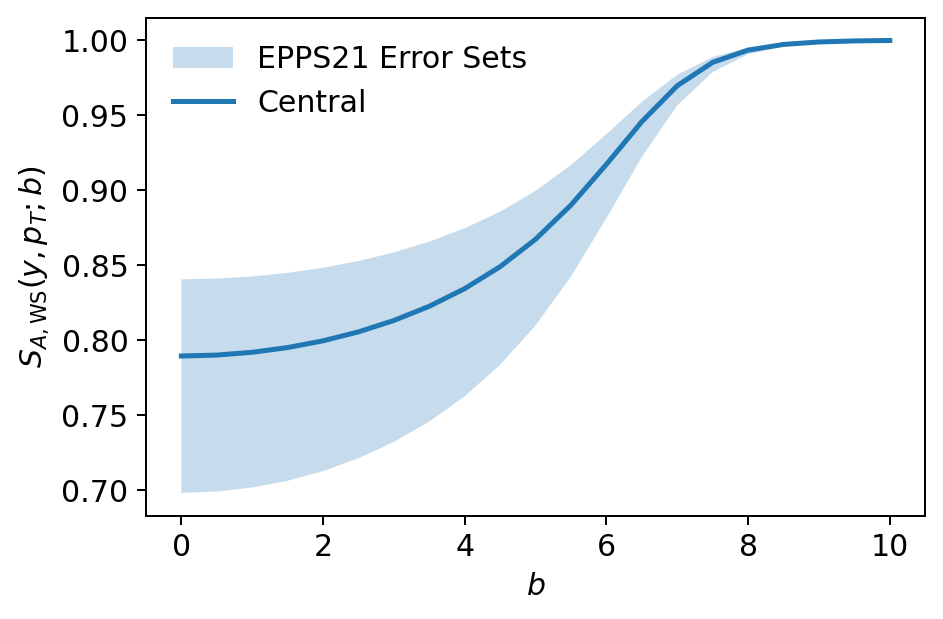

In [20]:
# # S_AWS(b; y, pT) vs b at fixed y, pT ---
b_list  = np.linspace(0,10, 21)
pT = 0.25
y = -2.5
SAWS_c = np.array([epps8.SAWS_ypt_b_set(y, pT, b, set_id=1) for b in b_list])
band_list = [epps8.SAWS_band_ypt_b(y, pT, b, cl=68.0) for b in b_list]
SAWS_lo, SAWS_hi = np.array(band_list).T

plt.figure(figsize=(5.4,3.6), dpi=180)
plt.fill_between(b_list, SAWS_lo, SAWS_hi, alpha=0.25, label="EPPS21 Error Sets")
plt.plot(b_list, SAWS_c, lw=2, label="Central")
plt.xlabel(r"$b$"); plt.ylabel(r"$S_{A,\mathrm{WS}}(y,p_T;b)$"); plt.legend(frameon=False); plt.tight_layout()

In [21]:
# from npdf_module import plot_K_vs_b, step_K_vs_y
# # K vs b at (y=+2.5, pT=5 GeV)
# fig, ax = plt.subplots(figsize=(5,3.2))
# plot_K_vs_b(ax, cm5, y=+2.5, pT=5.0, label="5.02 TeV")
# ax.legend(frameon=False); fig.tight_layout()

In [22]:
# # K vs y (stepped) at fixed b and pT
# y_edges = np.arange(-5.0, 5.0+1e-9, 0.5)
# dfK = cm5.K_vs_y_fixed_b_pt(y_edges, pt=5.0, b=2.0)       # b in fm
# fig, ax = plt.subplots(figsize=(5.8,3.2))
# step_K_vs_y(ax, dfK, label=r"$b=2\,\mathrm{fm}$"); ax.legend(frameon=False); fig.tight_layout()

## RpA vs Centrality

In [23]:
# ----- Centrality-dependent RpA plots (nPDF only) -----------------------
def plot_vs_centrality_percent(y_rng, pt_rng=PT_RANGE, cent_edges=CENT_EDGES,
                               save=None, ylim=(0.4,1.4), show_minbias=True):
    t5 = rpa_vs_centrality_table(cm5, r5, sys5.df_pa, cent_edges, y_rng, pt_rng, sigma5)
    t8 = rpa_vs_centrality_table(cm8, r8, sys8.df_pa, cent_edges, y_rng, pt_rng, sigma8)

    fig, ax = plt.subplots(figsize=(6.6,4.8))

    # 5.02 TeV (solid)
    X, C  = as_step(cent_edges, t5["r_central"])
    _, L  = as_step(cent_edges, t5["r_lo"])
    _, H  = as_step(cent_edges, t5["r_hi"])
    ax.fill_between(X, L, H, step="post", alpha=BAND_ALPHA, color=BAND_COLOR, zorder=2)
    ax.plot(X, C, drawstyle="steps-post", lw=2, color=BAND_COLOR, linestyle=LS_5, label="5.02 TeV", zorder=3)

    # 8.16 TeV (dashed, same color + hatch)
    X, C  = as_step(cent_edges, t8["r_central"])
    _, L  = as_step(cent_edges, t8["r_lo"])
    _, H  = as_step(cent_edges, t8["r_hi"])
    ax.fill_between(X, L, H, step="post", alpha=BAND_ALPHA, color=BAND_COLOR, zorder=2)
    ax.plot(X, C, drawstyle="steps-post", lw=2, color=BAND_COLOR, linestyle=LS_8, label="8.16 TeV", zorder=3.1)

    # Min-bias (flat band/line across the whole 0–100% range)
    # --- MIN-BIAS (flat band/line across 0–100%) ---
    if show_minbias:
        mb5 = cm5.minbias_in_window(r5, sys5.df_pa,
                                    y_min=y_rng[0], y_max=y_rng[1],
                                    pt_min=pt_rng[0], pt_max=pt_rng[1])
        mb8 = cm8.minbias_in_window(r8, sys8.df_pa,
                                    y_min=y_rng[0], y_max=y_rng[1],
                                    pt_min=pt_rng[0], pt_max=pt_rng[1])
        x0, x1 = float(cent_edges[0]), float(cent_edges[-1])

        # 5.02 TeV MB: solid (filled) band + dotted line
        mb5_line = _draw_minbias_band(ax, mb5["r_central"], mb5["r_lo"], mb5["r_hi"], x0, x1,
                   color=MB_BAND_COLOR, ls=LS_MB_5, label="5.02 TeV (min bias)", z=1.0)

        # 8.16 TeV MB: hatched outline band + dash-dot line (distinct)
        mb8_line = _draw_minbias_band(ax, mb8["r_central"], mb8["r_lo"], mb8["r_hi"], x0, x1,
                   color=MB_BAND_COLOR, ls=LS_MB_8, label="8.16 TeV (min bias)", z=1.05,
                   facecolor="none", edgecolor=MB_BAND_COLOR, hatch=HATCH_8, linewidth=0.8)
    else:
        mb5_line = mb8_line = None

    ax.set_xlabel("Centrality [%]"); ax.set_ylabel(r"$R_{pA}$"); ax.set_ylim(*ylim)
    ax.set_xticks(cent_edges); ax.set_xlim(0,100)
    note(ax, y_rng, pt_rng, cent_edges)
    ax.legend(frameon=False, loc="best")
    _cosmetics(ax)

    fig.tight_layout()
    if save: fig.savefig(save, bbox_inches="tight", dpi=300)
    plt.show()

def plot_vs_ncoll(y_rng, pt_rng=PT_RANGE, cent_edges=CENT_EDGES,
                  save=None, ylim=(0.6,1.4), show_minbias=True):
    ctab5 = cm5.centrality_table(cent_edges, sigmaNN_mb=sigma5)
    ctab8 = cm8.centrality_table(cent_edges, sigmaNN_mb=sigma8)

    t5 = rpa_vs_centrality_table(cm5, r5, sys5.df_pa, cent_edges, y_rng, pt_rng, sigma5)
    t8 = rpa_vs_centrality_table(cm8, r8, sys8.df_pa, cent_edges, y_rng, pt_rng, sigma8)

    x5 = ctab5["N_coll"].to_numpy(float); o5 = np.argsort(x5); x5 = x5[o5]
    x8 = ctab8["N_coll"].to_numpy(float); o8 = np.argsort(x8); x8 = x8[o8]

    c5, l5, h5 = t5["r_central"].to_numpy(float)[o5], t5["r_lo"].to_numpy(float)[o5], t5["r_hi"].to_numpy(float)[o5]
    c8, l8, h8 = t8["r_central"].to_numpy(float)[o8], t8["r_lo"].to_numpy(float)[o8], t8["r_hi"].to_numpy(float)[o8]

    fig, ax = plt.subplots(figsize=(6.6,4.8))

    ax.fill_between(x5, l5, h5, alpha=BAND_ALPHA, color=BAND_COLOR, zorder=2)
    ax.plot(x5, c5, lw=2, color=BAND_COLOR, linestyle=LS_5, marker="o", ms=4, label="5.02 TeV", zorder=3)
    ax.fill_between(x8, l8, h8, alpha=BAND_ALPHA, color=BAND_COLOR, zorder=2)
    ax.plot(x8, c8, lw=2, color=BAND_COLOR, linestyle=LS_8, marker="s", ms=4, label="8.16 TeV", zorder=3.1)

    ax.set_xlabel(r"$\langle N_{\mathrm{coll}}\rangle$"); ax.set_ylabel(r"$R_{pA}$"); ax.set_ylim(*ylim)
    note(ax, y_rng, pt_rng, cent_edges)
    _cosmetics(ax)

    # --- MIN-BIAS (flat band/line across x-span of data) ---
    if show_minbias:
        mb5 = cm5.minbias_in_window(r5, sys5.df_pa,
                                    y_min=y_rng[0], y_max=y_rng[1],
                                    pt_min=pt_rng[0], pt_max=pt_rng[1])
        mb8 = cm8.minbias_in_window(r8, sys8.df_pa,
                                    y_min=y_rng[0], y_max=y_rng[1],
                                    pt_min=pt_rng[0], pt_max=pt_rng[1])
        x0 = float(min(x5.min(), x8.min()))
        x1 = float(max(x5.max(), x8.max()))

        mb5_line = _draw_minbias_band(ax, mb5["r_central"], mb5["r_lo"], mb5["r_hi"], x0, x1,
                   color=MB5_COLOR, ls=LS_MB_5, label="5.02 TeV (min bias)", z=1.0)
        
        mb8_line = _draw_minbias_band(ax, mb8["r_central"], mb8["r_lo"], mb8["r_hi"], x0, x1,
                   color=MB8_COLOR, ls=LS_MB_8, label="8.16 TeV (min bias)", z=1.05,
                   facecolor="none", edgecolor=MB8_COLOR, hatch=HATCH_8, linewidth=0.8)
    else:
        mb5_line = mb8_line = None


    ax.legend(frameon=False, loc="best")
    fig.tight_layout()
    if save: fig.savefig(save, bbox_inches="tight", dpi=300)
    plt.show()

In [24]:
def threepanel_rpa_centrality(xmode="centrality", *,
                              pt_rng=PT_RANGE, cent_edges=CENT_EDGES,
                              ylim=(0.5,1.4), save=None,
                              legend_loc="lower right",
                              show_minbias=True):
    fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.2), sharey=True, constrained_layout=True)

    for ax, y_rng, _ in zip(axes, Y_RANGES_THREE, Y_LABELS):
        # compute once per panel
        t5 = rpa_vs_centrality_table(cm5, r5, sys5.df_pa, cent_edges, y_rng, pt_rng, sigma5)
        t8 = rpa_vs_centrality_table(cm8, r8, sys8.df_pa, cent_edges, y_rng, pt_rng, sigma8)

        if xmode.lower() == "centrality":
            # 5.02 TeV — solid band + solid line
            X, C  = as_step(cent_edges, t5["r_central"])
            _, L  = as_step(cent_edges, t5["r_lo"])
            _, H  = as_step(cent_edges, t5["r_hi"])
            ax.fill_between(X, L, H, step="post",
                            facecolor=BAND_COLOR, edgecolor=BAND_COLOR,
                            alpha=BAND_ALPHA_SOLID, zorder=2.0)
            line5, = ax.plot(X, C, drawstyle="steps-post", lw=2,
                             color=BAND_COLOR, linestyle=LS_5, label="5.02 TeV", zorder=3)

            # 8.16 TeV — hatched band + dashed line
            X, C  = as_step(cent_edges, t8["r_central"])
            _, L  = as_step(cent_edges, t8["r_lo"])
            _, H  = as_step(cent_edges, t8["r_hi"])
            ax.fill_between(X, L, H, step="post",
                            facecolor="none", edgecolor=BAND_COLOR,
                            hatch=HATCH_8, linewidth=0.8, zorder=3.0)
            line8, = ax.plot(X, C, drawstyle="steps-post", lw=2,
                             color=BAND_COLOR, linestyle=LS_8, label="8.16 TeV", zorder=3.1)

            ax.set_xlabel("Centrality [%]")
            ax.set_xticks(cent_edges); ax.set_xlim(0, 100)

            # --- MIN-BIAS (flat band/line across 0–100%) ---
            if show_minbias:
                mb5 = cm5.minbias_in_window(r5, sys5.df_pa,
                                            y_min=y_rng[0], y_max=y_rng[1],
                                            pt_min=pt_rng[0], pt_max=pt_rng[1])
                mb8 = cm8.minbias_in_window(r8, sys8.df_pa,
                                            y_min=y_rng[0], y_max=y_rng[1],
                                            pt_min=pt_rng[0], pt_max=pt_rng[1])
                x0, x1 = float(cent_edges[0]), float(cent_edges[-1])
                mb5_line = _draw_minbias_band(ax, mb5["r_central"], mb5["r_lo"], mb5["r_hi"], x0, x1,
                                              color=MB5_COLOR, ls=LS_MB_5, label="5.02 TeV (min bias)", z=1.0)
                mb8_line = _draw_minbias_band(ax, mb8["r_central"], mb8["r_lo"], mb8["r_hi"], x0, x1,
                                              color=MB8_COLOR, ls=LS_MB_8, label="8.16 TeV (min bias)", z=1.05)
            else:
                mb5_line = mb8_line = None

        else:  # x = <N_coll>
            ctab5 = cm5.centrality_table(cent_edges, sigmaNN_mb=sigma5)
            ctab8 = cm8.centrality_table(cent_edges, sigmaNN_mb=sigma8)

            x5 = ctab5["N_coll"].to_numpy(float); o5 = np.argsort(x5); x5 = x5[o5]
            x8 = ctab8["N_coll"].to_numpy(float); o8 = np.argsort(x8); x8 = x8[o8]

            c5, l5, h5 = t5["r_central"].to_numpy(float)[o5], t5["r_lo"].to_numpy(float)[o5], t5["r_hi"].to_numpy(float)[o5]
            c8, l8, h8 = t8["r_central"].to_numpy(float)[o8], t8["r_lo"].to_numpy(float)[o8], t8["r_hi"].to_numpy(float)[o8]

            ax.fill_between(x5, l5, h5, facecolor=BAND_COLOR, edgecolor=BAND_COLOR,
                            alpha=BAND_ALPHA_SOLID, zorder=2.0)
            line5, = ax.plot(x5, c5, lw=2, color=BAND_COLOR, linestyle=LS_5,
                             marker="o", ms=4, label="5.02 TeV", zorder=3)

            ax.fill_between(x8, l8, h8, facecolor="none", edgecolor=BAND_COLOR,
                            hatch=HATCH_8, linewidth=0.8, zorder=3.0)
            line8, = ax.plot(x8, c8, lw=2, color=BAND_COLOR, linestyle=LS_8,
                             marker="s", ms=4, label="8.16 TeV", zorder=3.1)

            ax.set_xlabel(r"$\langle N_{\mathrm{coll}}\rangle$")

            # --- MIN-BIAS (flat band/line across x-span of data) ---
            if show_minbias:
                mb5 = cm5.minbias_in_window(r5, sys5.df_pa,
                                            y_min=y_rng[0], y_max=y_rng[1],
                                            pt_min=pt_rng[0], pt_max=pt_rng[1])
                mb8 = cm8.minbias_in_window(r8, sys8.df_pa,
                                            y_min=y_rng[0], y_max=y_rng[1],
                                            pt_min=pt_rng[0], pt_max=pt_rng[1])
                x0 = float(min(x5.min(), x8.min()))
                x1 = float(max(x5.max(), x8.max()))
                mb5_line = _draw_minbias_band(ax, mb5["r_central"], mb5["r_lo"], mb5["r_hi"], x0, x1,
                                              color=MB5_COLOR, ls=LS_MB_5, label="5.02 TeV (Min bias)", z=1.0)
                mb8_line = _draw_minbias_band(ax, mb8["r_central"], mb8["r_lo"], mb8["r_hi"], x0, x1,
                                              color=MB8_COLOR, ls=LS_MB_8, label="8.16 TeV (Min bias)", z=1.05)
            else:
                mb5_line = mb8_line = None

        # y-axis and cosmetics
        ax.set_ylabel(r"$R_{pA}$"); ax.set_ylim(*ylim)
        _ranges_box(ax, y_rng, pt_rng)
        _cosmetics(ax)

        # legend INSIDE each subplot (now includes MB if shown)
        handles = [h for h in (line5, line8, mb5_line, mb8_line) if h is not None]
        ax.legend(handles=handles, frameon=False, loc=legend_loc, borderaxespad=0.6)

        if save: fig.savefig(save, bbox_inches="tight", dpi=300)

In [25]:
# # EXAMPLES (BACK and FOR windows)
# plot_vs_centrality_percent(Y_RANGES[0], ylim=(0.6,1.2), save=outdir/"npdf_RpA_vs_centrality_BACK_5v8.pdf")

# plot_vs_centrality_percent(Y_RANGES[1], ylim=(0.4,1.4),save=outdir/"npdf_RpA_vs_centrality_FOR_5v8.pdf")

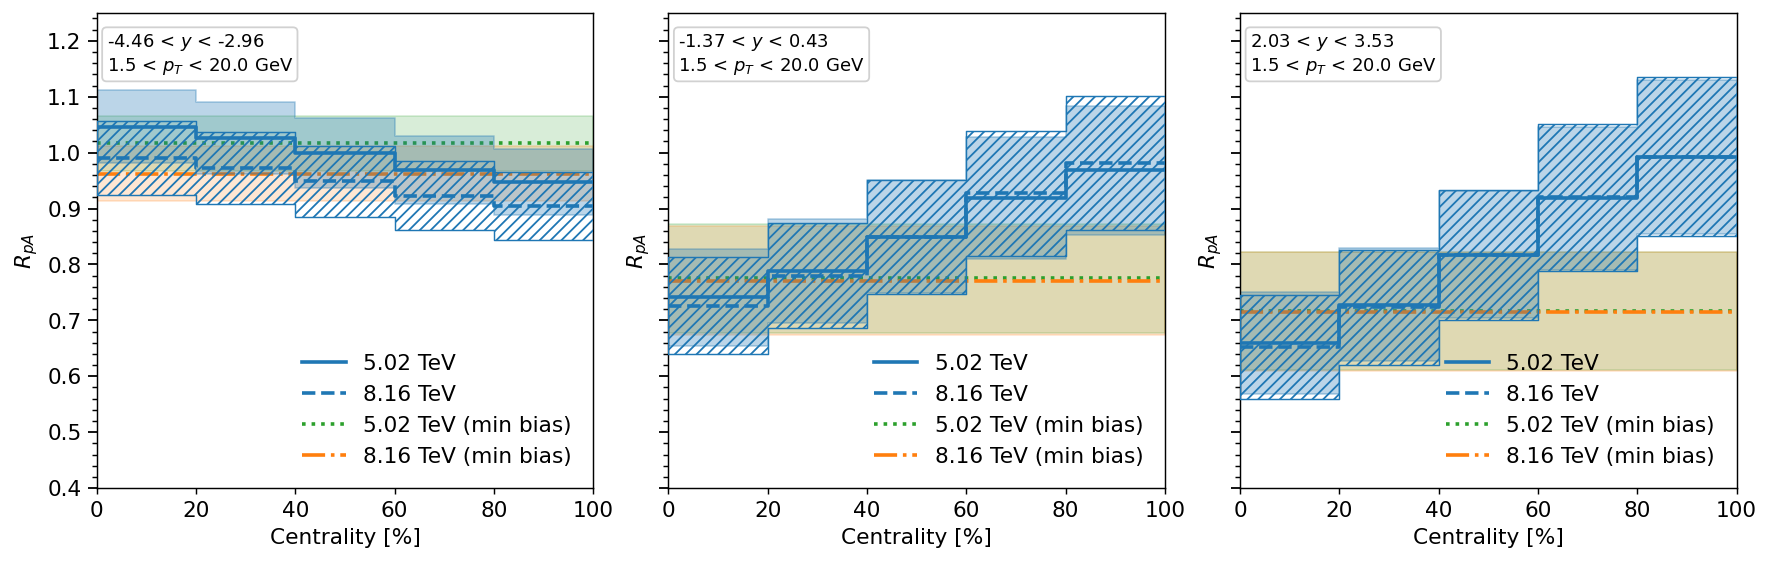

In [26]:
# Three-panel (BACK | MID | FOR) — choose xmode="centrality" or "ncoll"
threepanel_rpa_centrality(xmode="centrality", ylim=(0.4,1.25),
                          save=outdir/"npdf_RpA_vs_centrality_BACK_MID_FOR_5v8.pdf")


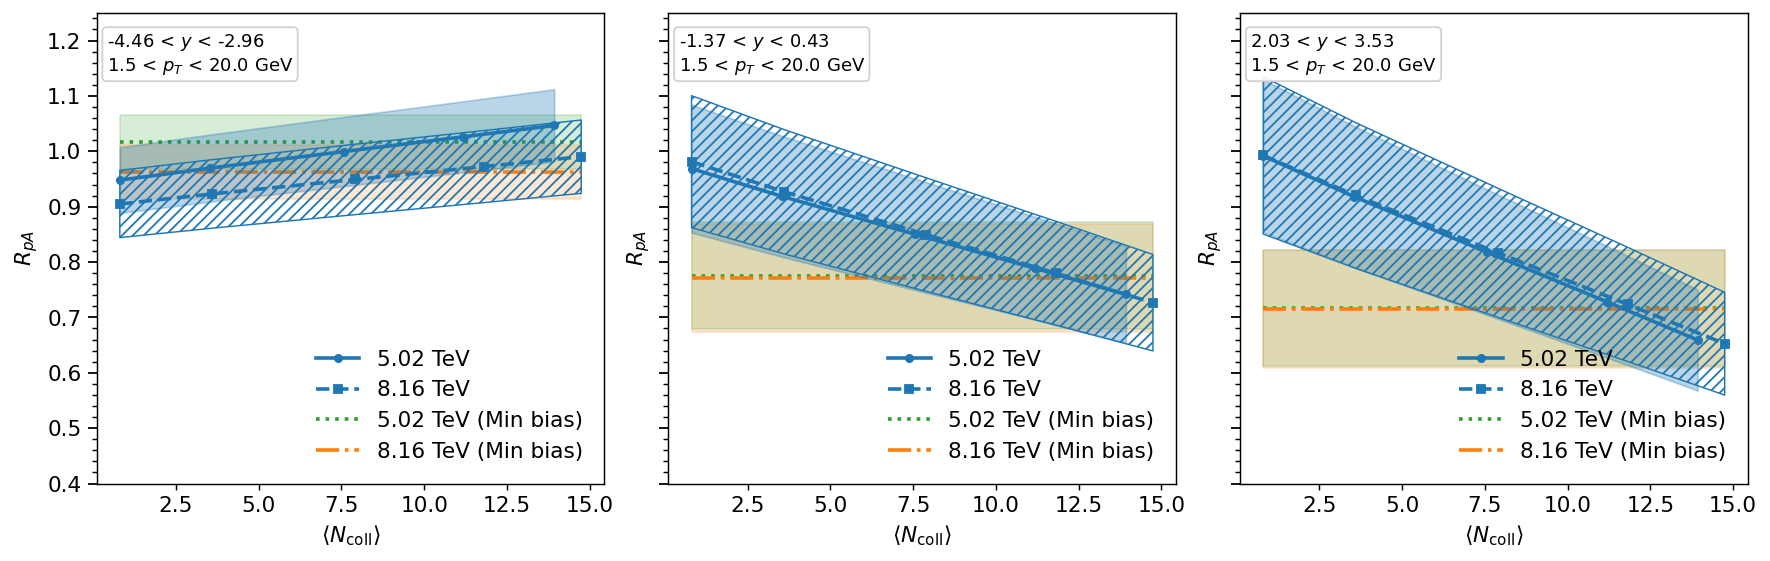

In [27]:
threepanel_rpa_centrality(xmode="ncoll", ylim=(0.4,1.25),
                          save=outdir/"npdf_RpA_vs_Ncoll_BACK_MID_FOR_5v8.pdf")

# threepanel_rpa_centrality(xmode="npart", ylim=(0.5,1.30),
#                           save=outdir/"npdf_RpA_vs_Npart_BACK_MID_FOR_5v8.pdf")

## RpA vs Rapidity

In [28]:
def _cent_labels(edges):
    return [f"{edges[i]}-{edges[i+1]}%" for i in range(len(edges)-1)]

def _step_arrays(edges, vals):
    """For drawstyle='steps-post'."""
    e = np.asarray(edges, float)
    v = np.asarray(vals,  float)
    return e, np.r_[v, v[-1]]

def _plot_step_band(ax, edges, c, lo, hi, *, color, label):
    X, C = _step_arrays(edges, c); _, L = _step_arrays(edges, lo); _, H = _step_arrays(edges, hi)
    ax.fill_between(X, L, H, step="post", alpha=BAND_ALPHA, color=color)
    ax.plot(X, C, drawstyle="steps-post", lw=2, color=color, label=label)

def _inside_note(ax, lines, loc=(0.02, 0.02)):
    ax.text(loc[0], loc[1], "\n".join(lines), transform=ax.transAxes,
            ha="left", va="bottom", fontsize=10,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9))

In [29]:
def rpa_vs_y_in_centbins_npdf(
    *, cm5, cm8, r5, r8, sys5, sys8,
    cent_edges, y_width=0.5, pt_range=(0.0, 20.0),
    sigma5=67.0, sigma8=71.0, ylim=(0.6, 1.4), ncols=3, include_minbias=True, save=None
):
    b5 = cm5.rpa_vs_y_in_centrality_bins(
        r5, sys5.df_pa, cent_edges, y_width=float(y_width), weight_mode="pp",w_floor_frac=0.05,pt_floor=2.0,
        pt_min=pt_range[0], pt_max=pt_range[1],
        sigmaNN_mb=sigma5, verbose=False
    )
    b8 = cm8.rpa_vs_y_in_centrality_bins(
        r8, sys8.df_pa, cent_edges, y_width=float(y_width), weight_mode="pp",w_floor_frac=0.05,pt_floor=2.0,
        pt_min=pt_range[0], pt_max=pt_range[1],
        sigmaNN_mb=sigma8, verbose=False
    )
    D5, D8 = dict(b5), dict(b8)
    labs = _cent_labels(cent_edges)

    if include_minbias:
        # Append one extra centrality bin "0-100%"
        b5_mb = dict(cm5.rpa_vs_y_in_centrality_bins(
            r5, sys5.df_pa, [0,100], y_width=float(y_width), weight_mode="pp",w_floor_frac=0.05,
            pt_min=pt_range[0], pt_max=pt_range[1], sigmaNN_mb=sigma5, verbose=False))
        b8_mb = dict(cm8.rpa_vs_y_in_centrality_bins(
            r8, sys8.df_pa, [0,100], y_width=float(y_width), weight_mode="pp",w_floor_frac=0.05,
            pt_min=pt_range[0], pt_max=pt_range[1], sigmaNN_mb=sigma8, verbose=False))
        D5.update(b5_mb); D8.update(b8_mb)
        labs = labs + ["0-100%"]  # will render as “min bias” panel

    n = len(labs); ncols = min(ncols, n); nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 3.8*nrows), sharey=True)
    axes = np.atleast_1d(axes).ravel()

    for ax, lab in zip(axes, labs):
        df5, df8 = D5.get(lab, pd.DataFrame()), D8.get(lab, pd.DataFrame())

        def _edges_from_df(df):
            if df.empty: return None
            if {"y_left","y_right"}.issubset(df.columns):
                return np.r_[df["y_left"], df["y_right"].iloc[-1]]
            if "y" in df.columns:
                return centers_to_left_edges(df["y"].to_numpy(float), width=float(y_width))
            return None

        # 5.02 TeV — solid band + solid line
        if not df5.empty:
            e5 = _edges_from_df(df5)
            X, C  = _step_arrays(e5, df5["r_central"])
            _, L  = _step_arrays(e5, df5["r_lo"])
            _, H  = _step_arrays(e5, df5["r_hi"])
            ax.fill_between(X, L, H, step="post",
                            facecolor=BAND_COLOR, edgecolor=BAND_COLOR,
                            alpha=BAND_ALPHA_SOLID, zorder=2.0)
            line5, = ax.plot(X, C, drawstyle="steps-post", lw=2, color=BAND_COLOR,
                             linestyle=LS_5, label="5.02 TeV", zorder=3.0)
        else:
            line5 = None

        # 8.16 TeV — hatched band + dashed line
        if not df8.empty:
            e8 = _edges_from_df(df8)
            X, C  = _step_arrays(e8, df8["r_central"])
            _, L  = _step_arrays(e8, df8["r_lo"])
            _, H  = _step_arrays(e8, df8["r_hi"])
            ax.fill_between(X, L, H, step="post",
                            facecolor="none", edgecolor=BAND_COLOR,
                            hatch=HATCH_8, linewidth=0.8, zorder=3.0)
            line8, = ax.plot(X, C, drawstyle="steps-post", lw=2, color=BAND_COLOR,
                             linestyle=LS_8, label="8.16 TeV", zorder=3.1)
        else:
            line8 = None

        ax.set_xlabel("y"); ax.set_ylabel(r"$R_{pA}$"); ax.set_ylim(*ylim)
        ax.set_xlim(-5.0, 5.0); ax.margins(x=0)
        _cent_box(ax, "Min bias" if lab=="0-100%" else lab)
        _kine_box(ax, [fr"$\Delta y={y_width}$",
                       fr"{pt_range[0]:.1f} < $p_T$ < {pt_range[1]:.1f} GeV"])
        _cosmetics(ax)

        handles = [h for h in (line5, line8) if h is not None]
        if handles:
            ax.legend(handles=handles, frameon=False, loc="upper right", borderaxespad=0.6)

    for ax in axes[len(labs):]:
        ax.axis("off")

    fig.tight_layout()
    if save: fig.savefig(save, bbox_inches="tight", dpi=300)
    plt.show()

/home/sawin/Desktop/Charmonia/charmonia_combined_analysis/code/npdf_module.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[col] = np.asarray(sub[col], float)
/home/sawin/Desktop/Charmonia/charmonia_combined_analysis/code/npdf_module.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[col] = np.asarray(sub[col], float)
/home/sawin/Desktop/Charmonia/charmonia_combined_analysis/code/npdf_module.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

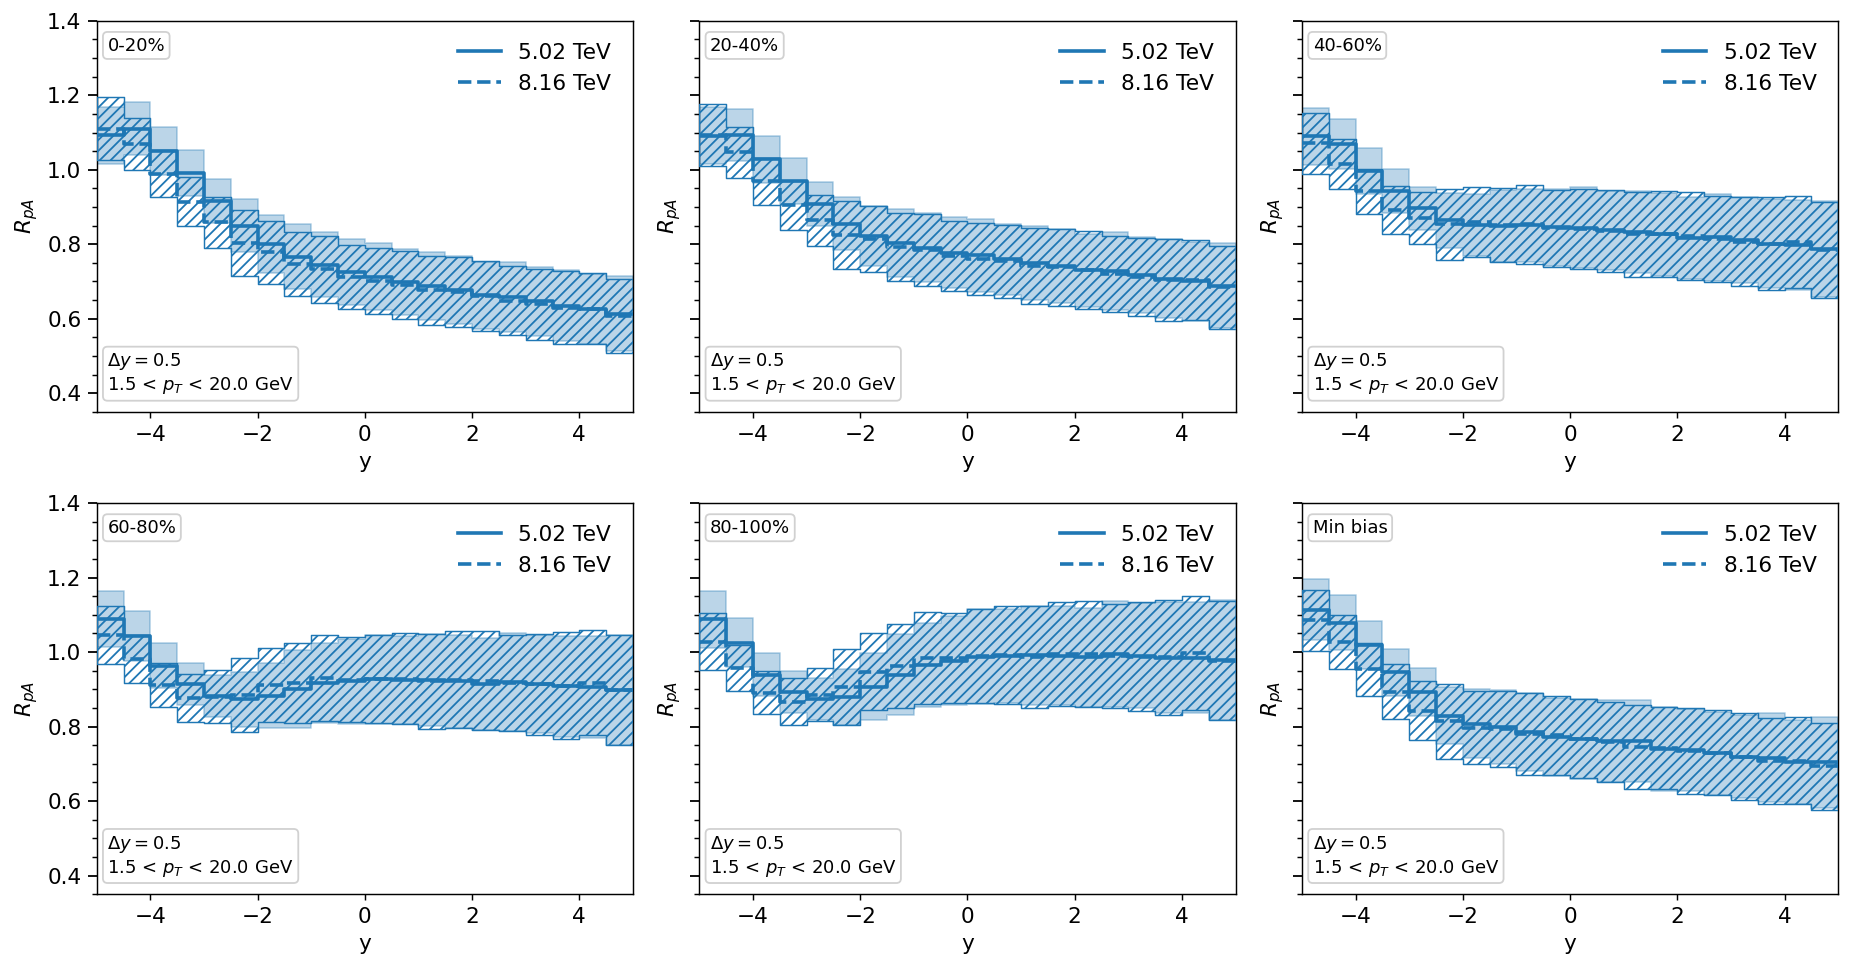

In [30]:
# RpA vs y (all centrality bins)
rpa_vs_y_in_centbins_npdf(
    cm5=cm5, cm8=cm8, r5=r5, r8=r8, sys5=sys5, sys8=sys8,
    cent_edges=CENT_EDGES, y_width=0.5, pt_range=PT_RANGE,
    sigma5=sigma5, sigma8=sigma8, ylim=(0.35,1.4), ncols=3,
    save=outdir/"npdf_RpA_vs_y_in_centbins_5v8.pdf"
)

## RpA vs Transverse Momentum

In [31]:
def rpa_vs_pt_in_centbins_npdf(
    *, cm5, cm8, r5, r8, sys5, sys8,
    cent_edges, y_range, pt_width=2.5,
    sigma5=67.0, sigma8=71.0, xlim=(0, 20), ylim=(0.6, 1.4),
    ncols=3, include_minbias=True, save=None
):
    b5 = cm5.rpa_vs_pt_in_centrality_bins(
        r5, sys5.df_pa, cent_edges,
        y_min=y_range[0], y_max=y_range[1],
        pt_width=float(pt_width), sigmaNN_mb=sigma5, verbose=False
    )
    b8 = cm8.rpa_vs_pt_in_centrality_bins(
        r8, sys8.df_pa, cent_edges,
        y_min=y_range[0], y_max=y_range[1],
        pt_width=float(pt_width), sigmaNN_mb=sigma8, verbose=False
    )
    D5, D8 = dict(b5), dict(b8)
    labs = _cent_labels(cent_edges)

    if include_minbias:
        b5_mb = dict(cm5.rpa_vs_pt_in_centrality_bins(
            r5, sys5.df_pa, [0,100], y_min=y_range[0], y_max=y_range[1],
            pt_width=float(pt_width), sigmaNN_mb=sigma5, verbose=False))
        b8_mb = dict(cm8.rpa_vs_pt_in_centrality_bins(
            r8, sys8.df_pa, [0,100], y_min=y_range[0], y_max=y_range[1],
            pt_width=float(pt_width), sigmaNN_mb=sigma8, verbose=False))
        D5.update(b5_mb); D8.update(b8_mb)
        labs = labs + ["0-100%"]

    n = len(labs); ncols = min(ncols, n); nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 3.8*nrows), sharey=True)
    axes = np.atleast_1d(axes).ravel()

    for ax, lab in zip(axes, labs):
        df5, df8 = D5.get(lab, pd.DataFrame()), D8.get(lab, pd.DataFrame())

        def _edges_from_df(df):
            if df.empty: return None
            if {"pt_left","pt_right"}.issubset(df.columns):
                return np.r_[df["pt_left"], df["pt_right"].iloc[-1]]
            if "pt" in df.columns:
                return centers_to_left_edges(df["pt"].to_numpy(float), width=float(pt_width))
            return None

        if not df5.empty:
            e5 = _edges_from_df(df5)
            X, C  = _step_arrays(e5, df5["r_central"])
            _, L  = _step_arrays(e5, df5["r_lo"])
            _, H  = _step_arrays(e5, df5["r_hi"])
            ax.fill_between(X, L, H, step="post",
                            facecolor=BAND_COLOR, edgecolor=BAND_COLOR,
                            alpha=BAND_ALPHA_SOLID, zorder=2.0)
            line5, = ax.plot(X, C, drawstyle="steps-post", lw=2, color=BAND_COLOR,
                             linestyle=LS_5, label="5.02 TeV", zorder=3.0)
        else:
            line5 = None

        if not df8.empty:
            e8 = _edges_from_df(df8)
            X, C  = _step_arrays(e8, df8["r_central"])
            _, L  = _step_arrays(e8, df8["r_lo"])
            _, H  = _step_arrays(e8, df8["r_hi"])
            ax.fill_between(X, L, H, step="post",
                            facecolor="none", edgecolor=BAND_COLOR,
                            hatch=HATCH_8, linewidth=0.8, zorder=3.0)
            line8, = ax.plot(X, C, drawstyle="steps-post", lw=2, color=BAND_COLOR,
                             linestyle=LS_8, label="8.16 TeV", zorder=3.1)
        else:
            line8 = None

        ax.set_xlabel(r"$p_T$ [GeV]"); ax.set_ylabel(r"$R_{pA}$")
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        _cent_box(ax, "Min bias" if lab=="0-100%" else lab)
        _kine_box(ax, [fr"{y_range[0]:.2f} < $y$ < {y_range[1]:.2f}",
                       fr"$\Delta p_T={pt_width}$"])
        _cosmetics(ax)

        handles = [h for h in (line5, line8) if h is not None]
        if handles:
            ax.legend(handles=handles, frameon=False, loc="lower right", borderaxespad=0.6)

    for ax in axes[len(labs):]:
        ax.axis("off")

    fig.tight_layout()
    if save: fig.savefig(save, bbox_inches="tight", dpi=300)
    plt.show()

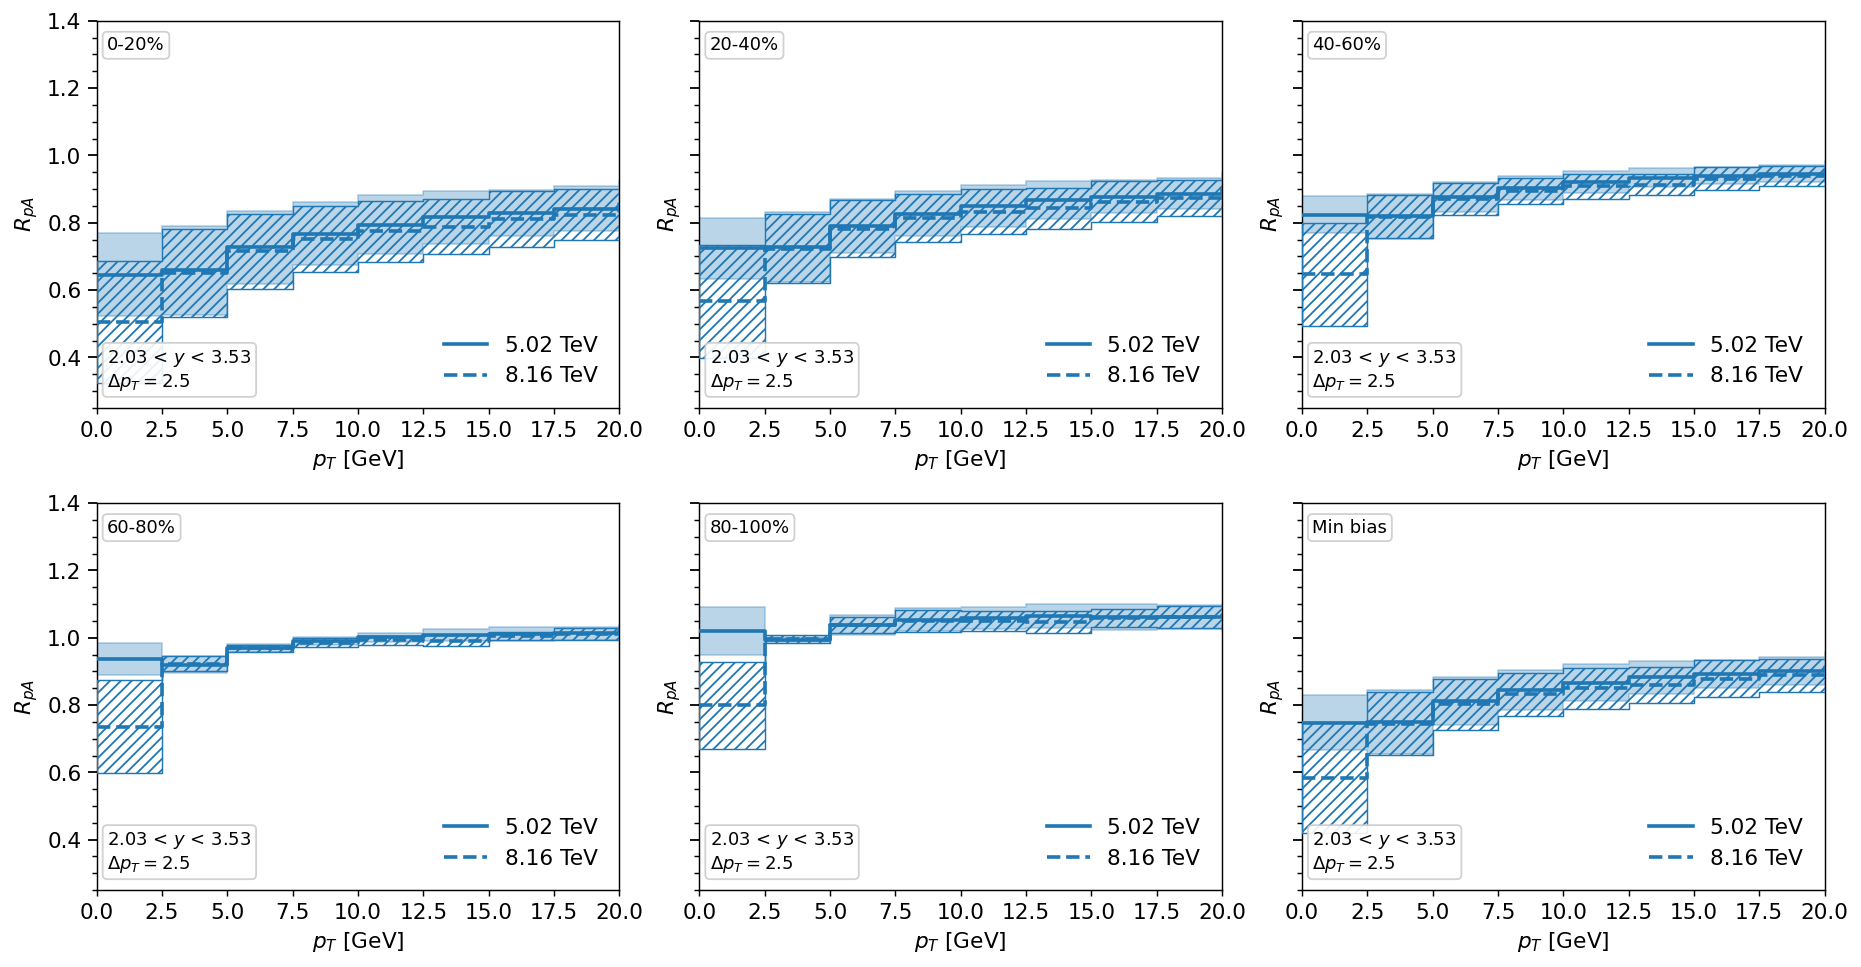

In [32]:
# RpA vs pT — Forward
rpa_vs_pt_in_centbins_npdf(
    cm5=cm5, cm8=cm8, r5=r5, r8=r8, sys5=sys5, sys8=sys8,
    cent_edges=CENT_EDGES, y_range=(2.03,3.53), pt_width=2.5,
    sigma5=sigma5, sigma8=sigma8, xlim=(0,20), ylim=(0.25,1.4), ncols=3,
    save=outdir/"npdf_RpA_vs_pT_in_centbins_FOR_5v8.pdf" 
)

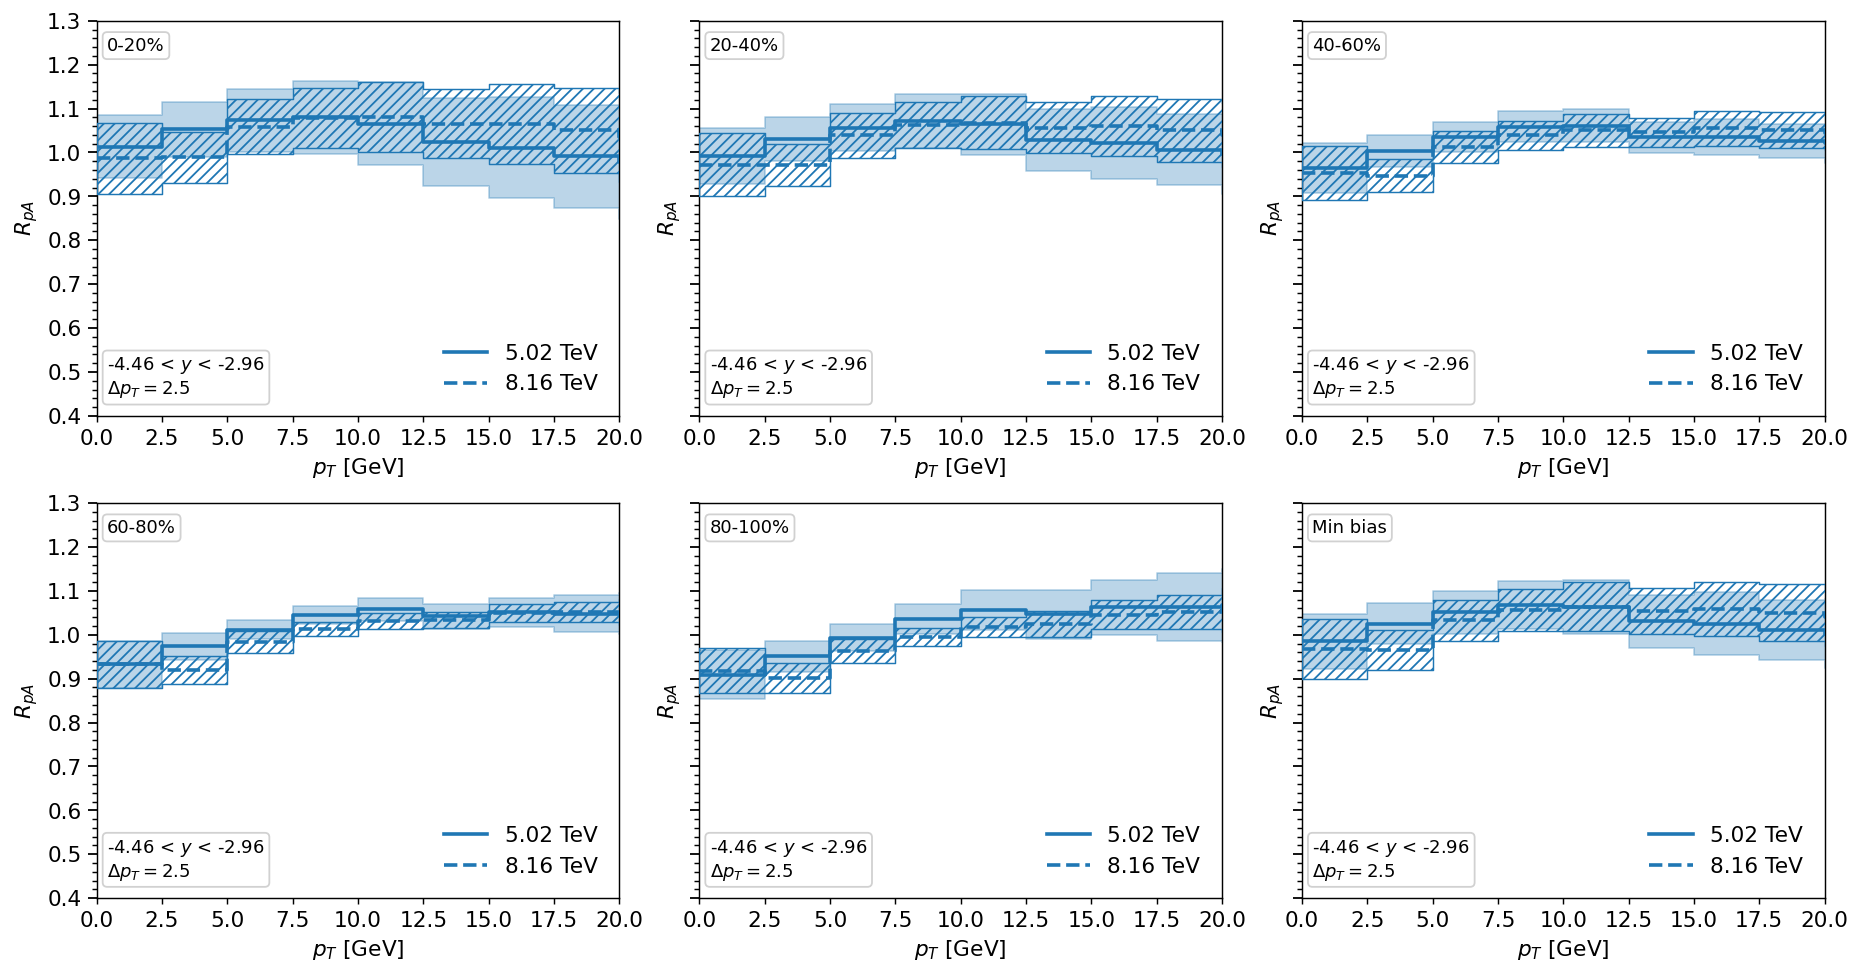

In [33]:
# Backward rapidity
rpa_vs_pt_in_centbins_npdf(
    cm5=cm5, cm8=cm8, r5=r5, r8=r8, sys5=sys5, sys8=sys8,
    cent_edges=CENT_EDGES, y_range=(-4.46,-2.96), pt_width=2.5,
    sigma5=sigma5, sigma8=sigma8, xlim=(0,20), ylim=(0.4,1.30), ncols=3,
    save=outdir/"npdf_RpA_vs_pT_in_centbins_BACK_5v8.pdf"
)

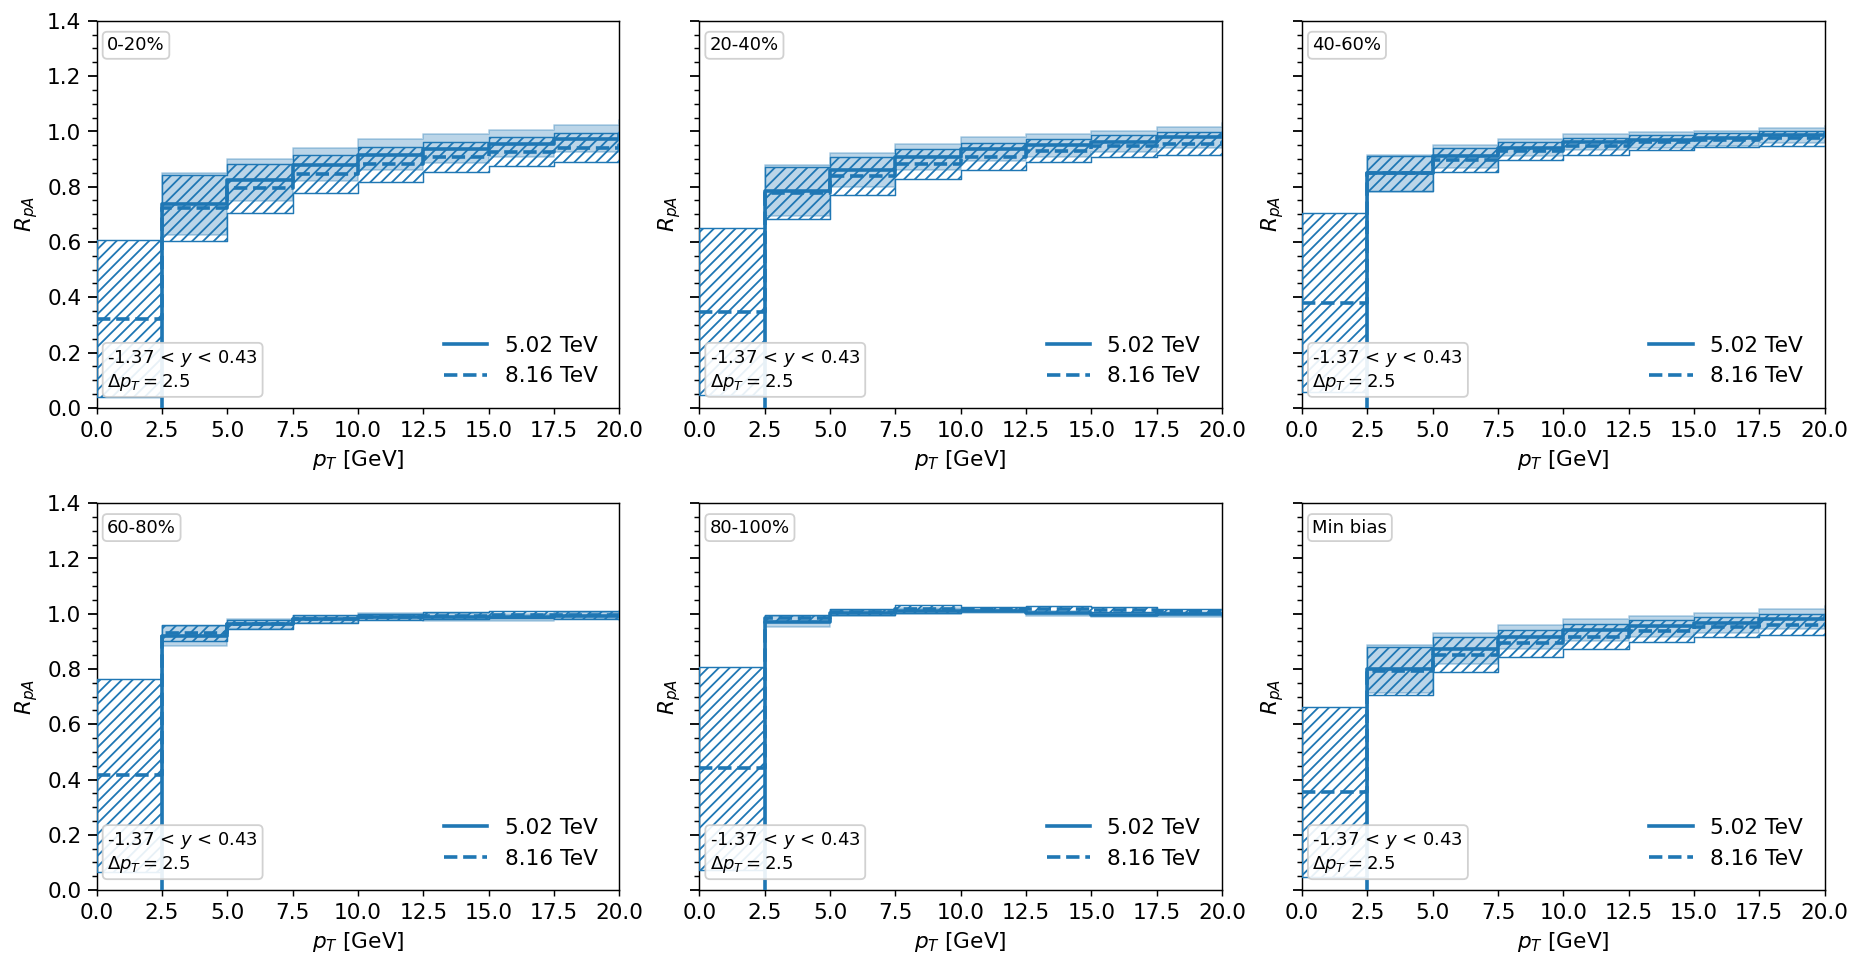

In [34]:
# Central rapidity
rpa_vs_pt_in_centbins_npdf(
    cm5=cm5, cm8=cm8, r5=r5, r8=r8, sys5=sys5, sys8=sys8,
    cent_edges=CENT_EDGES, y_range=(-1.37,0.43), pt_width=2.5,
    sigma5=sigma5, sigma8=sigma8, xlim=(0,20), ylim=(0.0,1.4), ncols=3,
    save=outdir/"npdf_RpA_vs_pT_in_centbins_CEN_5v8.pdf"
)